In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import spacepy.time as spt
import spacepy.omni as om

Qin-Denton/OMNI2 data not found in current format. This module has limited functionality.
Run spacepy.toolbox.update(QDomni=True) to download data


In [2]:
# On charge une bonne période de données
ticks = spt.tickrange('2002-01-01T00:00:00', '2005-01-01T00:00:00', deltadays = 1./24.)
d = om.get_omni(ticks)

Kp = d['Kp']
Bz = d['BzIMF']
V  = d['velo']
N  = d['dens']
dates = d['ticks'].UTC

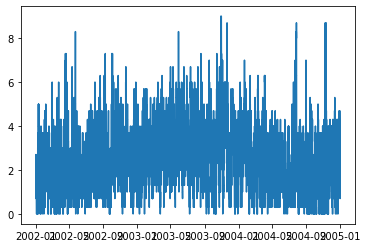

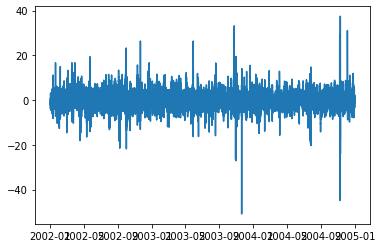

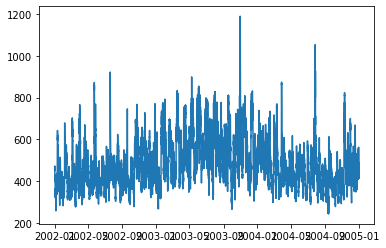

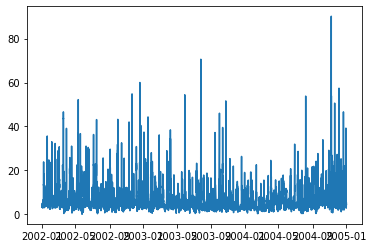

In [3]:
for d in (Kp, Bz, V, N):
    plt.figure()
    plt.plot(dates, d)

In [4]:
input_data = np.stack((Bz,V,N)).T
output_data = Kp[:,None]

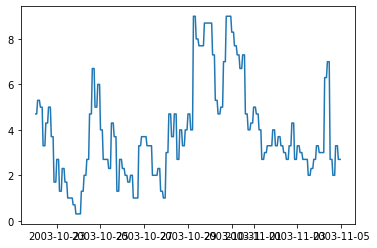

In [5]:
# Sélection d'une période de test:
from datetime import datetime
test_min, test_max = datetime(2003,10,22), datetime(2003,11,5)
in_test = np.logical_and(dates > test_min, dates < test_max)
train_index, = np.nonzero(np.logical_not(in_test))
test_index,  = np.nonzero(in_test)

X_train, X_test = input_data[train_index], input_data[test_index]
y_train, y_test = output_data[train_index], output_data[test_index]

plt.plot(dates[test_index], y_test)

In [6]:
SVR = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

1.3753116258448657

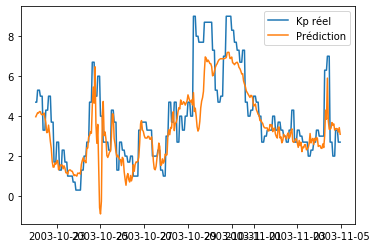

In [7]:
model = SVR.fit(X_train, y_train.ravel())

p_test = model.predict(X_test)
plt.plot(dates[test_index], y_test)
plt.plot(dates[test_index], p_test)
plt.legend(("Kp réel", "Prédiction"))
np.sqrt(mean_squared_error(y_test, p_test))

In [ ]:

tss = TimeSeriesSplit(n_splits=100)
# Évaluation de l'erreur du model:
errors = []
m_dates = []
for train_index, test_index in tss.split(input_data, output_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data[train_index], output_data[test_index]
    dates_test = dates[test_index]
    model = SVR.fit(X_train, y_train.ravel())
    p_test = model.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, p_test))
    errors.append(error)
    m_dates.append(dates_test[len(test_index)//2])
    #plt.figure()
    #plt.plot(dates_test, y_test)
    #plt.plot(dates_test, p_test)


In [ ]:
plt.plot(m_dates,errors)

# Évolution de l'erreur moyenne en fonction du temps. 
# En 1994/1995, deux nouveaux satellites (ACE,WIND) sont mis en services.
# Ce qui explique la forte baisse de l'erreur (moins de trous dans les données).